In [1]:
import tensorflow as tf

# suppress warnings for cleaner output
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import pandas as pd
import cv2
import os
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from PIL import Image
import numpy as np
import math
from mtcnn.mtcnn import MTCNN  # Assuming you have MTCNN installed
import matplotlib.pyplot as plt
import contextlib

from numpy import asarray
# import sys
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception

from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import StratifiedKFold
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.utils import class_weight
from keras.models import load_model


In [6]:
# Read the CSV file
data = pd.read_csv("./Dataset/asian_people.csv")

# Create folders for classes
classes = data['ethnicity'].str.replace(' ', '_').unique()
for class_name in classes:
    os.makedirs(class_name, exist_ok=True)
classes

array(['South_Asia', 'East_Asia', 'Middle_East'], dtype=object)

In [8]:
# Function to extract frames from videos and store directly in respective folders
def extract_frames_and_store(video_path, class_name, gender, duration, id):
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    print(f'Video read success: {success}')
    count = 1
    ethnicity = class_name.replace(' ', '_')
    while success:
        frame_path = os.path.join(ethnicity, f"{ethnicity}_{gender}_{id}_{count}.jpg")
        resized_image = cv2.resize(image, (224, 224))
        cv2.imwrite(frame_path, resized_image)  
        success, image = vidcap.read()

        if ethnicity != 'Middle_East' :
            success, image = vidcap.read()
        elif (count / vidcap.get(cv2.CAP_PROP_FPS)) >= (duration - 2):
            break

        count += 1
    print(f"ID-{id} = {count} images.")
            
# Loop through each row in the dataframe
for index, row in data.iterrows():
    # Extract frames from videos and store directly in respective folders
    extract_frames_and_store("Dataset/files" + row['video_link'], row['ethnicity'], row['gender'], row['video_duration'], row['id'])

Video read success: True
ID-1 = 79 images.
Video read success: True
ID-2 = 111 images.
Video read success: True
ID-3 = 124 images.
Video read success: True
ID-4 = 162 images.
Video read success: True
ID-5 = 126 images.
Video read success: True
ID-6 = 120 images.
Video read success: True
ID-7 = 179 images.
Video read success: True
ID-8 = 151 images.
Video read success: True
ID-9 = 161 images.
Video read success: True
ID-10 = 186 images.


In [9]:
for path in classes:
    print(f"{path} : {len(os.listdir(path))} images.")

South_Asia : 591 images.
East_Asia : 679 images.
Middle_East : 120 images.


Original img : 
AxesImage(shape=(224, 224, 3))


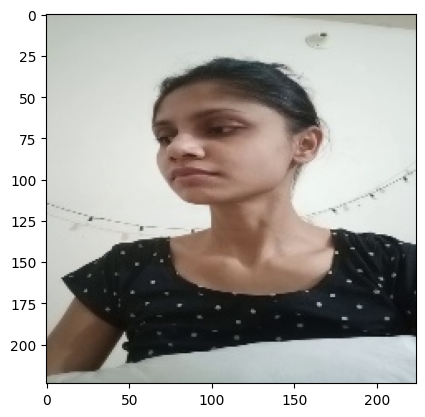

In [27]:
# function for face detection with mtcnn

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()

    
    # suppress stdout
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        print("will not print")
    # detect faces in the image
        results = detector.detect_faces(pixels)
        # print(len(results))

        # Face Alignment
        if len(results) == 0:
            print('Exiting...')
            return pixels
        print(results)
        
        x1, y1 = results[0]["keypoints"]["right_eye"]
        x2, y2 = results[0]["keypoints"]["left_eye"]
        a = abs(y1 - y2)
        b = abs(x2 - x1)
        c = math.sqrt(a*a + b*b)
        alpha= np.arccos(b/c) # radians
        alpha = (alpha * 180)/math.pi
        print(f'y2(left) ={y2}, y1={y1}')
        if y1 < y2:
            print('-ve')
            alpha = -alpha
        print(f"alpha = {alpha} deg")
        rotated_img = image.rotate(alpha)

        # convert to array
        rotated_arr = asarray(rotated_img)

        # detect faces in the image
        results = detector.detect_faces(rotated_arr)
        print(results)

    if len(results) == 0:
        # print('Exiting..') #############################################
        return pixels

    # print(f"alpha = {alpha} deg")
    # restore stdout

    # Face crop
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # print(f'x1 = {x1}, y1 = {y1}')
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    pad = 15
    face = rotated_arr[y1-pad:y2+pad, x1-pad:x2+pad]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

img_path = "South_Asia\South_Asia_FEMALE_10_42.jpg"
# img_path = "East_Asia\East_Asia_FEMALE_4_81.jpg"

print('Original img : ')
print(plt.imshow(asarray(Image.open(img_path))))

# plt.imshow(extract_face('East_Asia\East_Asia_FEMALE_3_72.jpg'))



Extracted face
AxesImage(shape=(224, 224, 3))


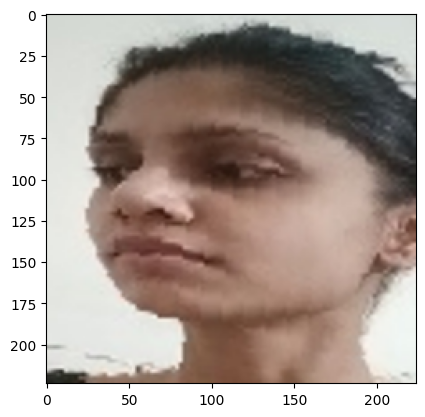

In [28]:
print('Extracted face')
print(plt.imshow(extract_face(img_path)))

In [20]:

# Define the directories
# source_dir = os.getcwd()  # Update with the directory containing the class folders
target_dir = "Train_Test_Sets"

# Create train, validation, and test directories
train_dir = os.path.join(target_dir, "Train")
test_dir = os.path.join(target_dir, "Test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the split ratios
train_ratio = 0.8
test_ratio = 0.2

# Loop through each class folder
for class_name in classes:
    if os.path.isdir(class_name):
        class_images = os.listdir(class_name)
        random.shuffle(class_images)
        
        num_train = int(len(class_images) * train_ratio)
        num_test = len(class_images) - num_train

        # Divide images into train and test sets
        train_images = class_images[:num_train]
        test_images = class_images[num_train:]
        
        # Copy images to respective directories
        for img_name in tqdm(train_images, total=len(train_images), desc=f"{class_name}: Processing Train imgs"):
            src = os.path.join(class_name, img_name)
            dst = os.path.join(train_dir, class_name, img_name)
            # print(src, dst)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            cv2.imwrite(dst, extract_face(src)[:, :, ::-1])
            
        
        for img_name in tqdm(test_images, total=len(test_images), desc=f"{class_name}Processing Test imgs"):
            src = os.path.join(class_name, img_name)
            dst = os.path.join(test_dir, class_name, img_name)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            cv2.imwrite(dst, extract_face(src)[:, :, ::-1])



Middle_EastProcessing Test imgs: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


In [25]:
import os

file_count = sum(len(files) for _, _, files in os.walk(target_dir))
print(file_count)

1390


In [7]:
# Define function to get image paths
def get_image_paths(directory):
    image_paths = []
    labels = []
    for class_name in classes:
        path = f'./{directory}/{class_name}'
        # print(path)
        class_images = [os.path.join(path, pics) for pics in os.listdir(path)]
        image_paths.extend(class_images)
        labels.extend([class_name] * len(class_images))
    return image_paths, labels

# Get image paths and labels for train and test sets
train_dir = '/Train_Test_Sets/Train'
test_dir = '/Train_Test_Sets/Test'

train_image_paths, train_labels = get_image_paths(train_dir)
test_image_paths, test_labels = get_image_paths(test_dir)

# Create DataFrame for train set
train_df = pd.DataFrame({'image_path': train_image_paths, 'label': train_labels})

# Create DataFrame for test set
test_df = pd.DataFrame({'image_path': test_image_paths, 'label': test_labels})

# Print first few rows of train and test DataFrames
print("Train DataFrame:")
print(train_df.head())
print("Test DataFrame:")
print(test_df.head())


Train DataFrame:
                                          image_path       label
0  .//Train_Test_Sets/Train/South_Asia\South_Asia...  South_Asia
1  .//Train_Test_Sets/Train/South_Asia\South_Asia...  South_Asia
2  .//Train_Test_Sets/Train/South_Asia\South_Asia...  South_Asia
3  .//Train_Test_Sets/Train/South_Asia\South_Asia...  South_Asia
4  .//Train_Test_Sets/Train/South_Asia\South_Asia...  South_Asia
Test DataFrame:
                                          image_path       label
0  .//Train_Test_Sets/Test/South_Asia\South_Asia_...  South_Asia
1  .//Train_Test_Sets/Test/South_Asia\South_Asia_...  South_Asia
2  .//Train_Test_Sets/Test/South_Asia\South_Asia_...  South_Asia
3  .//Train_Test_Sets/Test/South_Asia\South_Asia_...  South_Asia
4  .//Train_Test_Sets/Test/South_Asia\South_Asia_...  South_Asia


In [8]:
train_df

,image_path,label
0,.//Train_Test_Sets/Train/South_Asia\South_Asia...,South_Asia
1,.//Train_Test_Sets/Train/South_Asia\South_Asia...,South_Asia
2,.//Train_Test_Sets/Train/South_Asia\South_Asia...,South_Asia
3,.//Train_Test_Sets/Train/South_Asia\South_Asia...,South_Asia
4,.//Train_Test_Sets/Train/South_Asia\South_Asia...,South_Asia
...,...,...
1106,.//Train_Test_Sets/Train/Middle_East\Middle_Ea...,Middle_East
1107,.//Train_Test_Sets/Train/Middle_East\Middle_Ea...,Middle_East
1108,.//Train_Test_Sets/Train/Middle_East\Middle_Ea...,Middle_East
1109,.//Train_Test_Sets/Train/Middle_East\Middle_Ea...,Middle_East


In [28]:
train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.vgg16.preprocess_input,
    brightness_range=(0.8, 1.2),
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.vgg16.preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',  # Column containing input images
    y_col='label',  # Column containing target labels
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',  # Column containing input images
    y_col='label',  # Column containing target labels
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    shuffle=False  # Set to False to maintain order for evaluation
)

Found 1111 validated image filenames belonging to 3 classes.
Found 279 validated image filenames belonging to 3 classes.


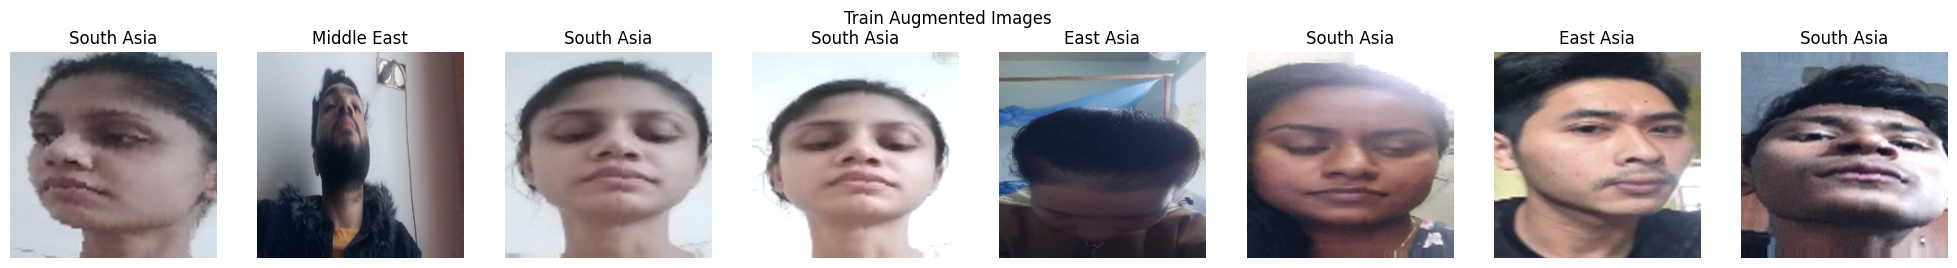

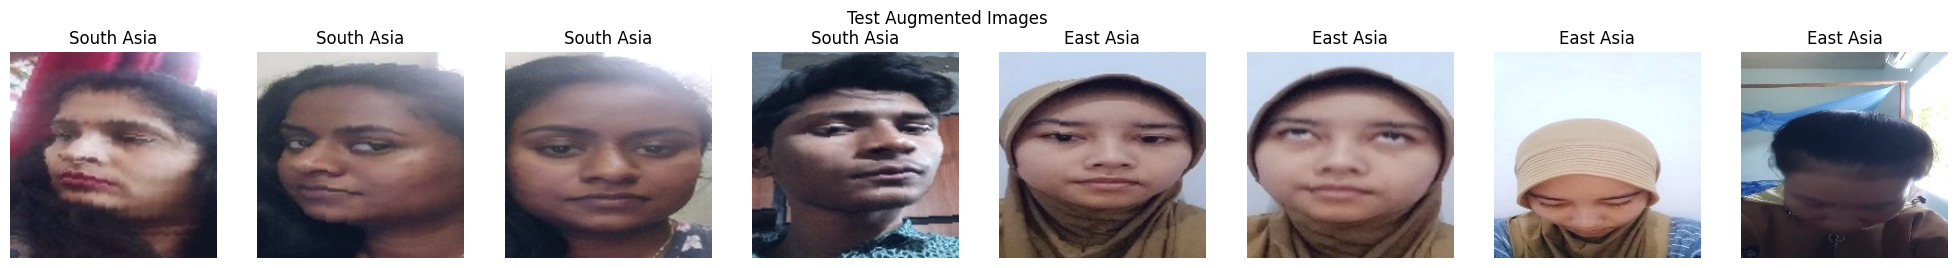

In [30]:


def plot_aug_images(generator, title):
    fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(25, 3))
    fig.suptitle(title)

    for i in range(8):
        # Get a batch of images and labels from the generator
        
        batch = next(generator)
        images = batch[0]
        labels_batch = batch[1]
    
        # Pick one image from the batch
        image = images[i]
        # Rescale and clip the image to the range [0, 1] to make it display legible.
        image = ((image+127)/255)[:, :, ::-1]
        image = np.clip(image, 0, 1)
        
        # print(image)
        # print(f'shape = {image.shape}')
        label = labels_batch[i]
        # Plot raw pixel data
        ax[i].imshow(image)
        ax[i].axis('off')
        # print(f'label = {label}')
        if np.array_equal(label, [0, 0, 1]):
            title = "South Asia"
        elif np.array_equal(label, [0, 1, 0]):
            title = "Middle East"
        else:
            title = "East Asia"
        ax[i].set_title(title)

    plt.show()

# Plot 5 augmented train images
plot_aug_images(train_generator, "Train Augmented Images")
plot_aug_images(test_generator, "Test Augmented Images")


In [ ]:
# Graphs

#There should be proper labelling of graphs, show legends.
# Plotting curves function

# Better way : metrics = list(history.keys())[:4]
def plot_curves(history, metrics = ['loss', 'accuracy', 'precision', 'recall']):
    plt.figure(figsize=(15, 3))

    # Train Loss vs Validation Loss
    plt.subplot(1, 4, 1)
    plt.plot(history.history[metrics[0]], label='Train Loss')
    plt.plot(history.history[f'val_{metrics[0]}'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Train Accuracy vs Validation Accuracy
    plt.subplot(1, 4, 2)
    plt.plot(history.history[metrics[1]], label='Train Accuracy')
    plt.plot(history.history[f'val_{metrics[1]}'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(1, 4, 3)
    plt.plot(history.history[metrics[2]], label='Train Precision')
    plt.plot(history.history[f'val_{metrics[2]}'], label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(1, 4, 4)
    plt.plot(history.history[metrics[3]], label='Train Recall')
    plt.plot(history.history[f'val_{metrics[3]}'], label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
test_generator.class_indices

{'East_Asia': 0, 'Middle_East': 1, 'South_Asia': 2}

In [18]:
# Confusion matrix and classification report

def plot_confusion_mat(model, test_df, preprocess_func):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)

    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',  # Column containing input images
        y_col='label',  # Column containing target labels
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical',
        shuffle=False  # Set to False to maintain order for evaluation
    )

    true_labels = test_generator.labels
    predictions = np.argmax(model.predict(test_generator), axis=1)


    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    classes = ['East_Asia', 'Middle_East', 'South_Asia']
    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Generate classification report
    report = classification_report(true_labels, predictions, target_names=classes)

    print("__Classification Report__ :")
    print(report)

In [31]:
# fit_model_KFoldCrossValidate()
def fit_model_KFoldCrossValidate(input_model, model_name, preprocess_func, train_df, test_df):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    train_y = train_df.label
    train_x = train_df.drop(['label'], axis=1)

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_func,
        brightness_range=(0.8, 1.2),
        shear_range=0.2,
        zoom_range=0.1,
        fill_mode="nearest"
    )

    test_datagen = ImageDataGenerator(
        # rescale=1./255,
        preprocessing_function=preprocess_func
    )

    # Initialize lists to store evaluation metrics
    accuracies = []
    max_acc = 0

    # Iterate over folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_x, train_y)):

        x_train_df = train_df.iloc[train_idx]

        x_valid_df = train_df.iloc[val_idx]

        print(f"\nFold {fold+1}")

        # Load pre-trained VGG16 model
        input_shape = (224, 224, 3)

        model = input_model

        # Generate batches of data
        train_generator = train_datagen.flow_from_dataframe(
            x_train_df,
            x_col='image_path',  # Column containing input images
            y_col='label',  # Column containing target labels
            target_size=(224, 224),
            batch_size=10,
            class_mode='categorical'
        )

        # Generate batches of data from the test data directory
        val_generator = test_datagen.flow_from_dataframe(
            x_valid_df,
            x_col='image_path',  # Column containing input images
            y_col='label',  # Column containing target labels
            target_size=(224, 224),
            batch_size=10,
            class_mode='categorical',
            shuffle=False  # Set to False to maintain order for evaluation
        )

        # Compile the model
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Precision(),
                                                                                    keras.metrics.Recall(),])

        # Train the model
        history = model.fit(train_generator, validation_data=val_generator, epochs=4, batch_size=32)

        test_generator = test_datagen.flow_from_dataframe(
            test_df,
            x_col='image_path',  # Column containing input images
            y_col='label',  # Column containing target labels
            target_size=(224, 224),
            batch_size=10,
            class_mode='categorical',
            shuffle=False  # Set to False to maintain order for evaluation
        )
        # Evaluate the model
        print("Test set evaluation:")
        evaluation = model.evaluate(test_generator)

        # Extract evaluation metrics
        accuracy = evaluation[1]
        accuracies.append(accuracy)
        if accuracy > max_acc:
            print('Entered')
            max_hist = history
            max_acc = accuracy
            model.save(f'./Models/best_{model_name}_model.h5')
            print('Saved model')

    # Calculate mean evaluation metrics across folds
    mean_accuracy = np.mean(accuracies)
    print("Mean Accuracy:", mean_accuracy)
    return max_hist


In [35]:

input_shape = (224, 224, 3)
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
VGG16_model.trainable = False
VGG16_model.summary()

model = Sequential()
model.add(tf.keras.layers.Reshape(input_shape))
model.add(VGG16_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(3,activation='softmax'))
# model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6287 (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
vgg_history = fit_model_KFoldCrossValidate(model, 'vgg16', keras.applications.vgg16.preprocess_input, train_df, test_df)


Fold 1
Found 888 validated image filenames belonging to 3 classes.
Found 223 validated image filenames belonging to 3 classes.


Epoch 1/4
89/89 [==============================] - 81s 891ms/step - loss: 0.9386 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/4
89/89 [==============================] - 77s 870ms/step - loss: 0.0388 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - val_loss: 2.8492 - val_accuracy: 0.9641 - val_precision: 0.9641 - val_recall: 0.9641
Epoch 3/4
89/89 [==============================] - 79s 886ms/step - loss: 0.6153 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
89/89 [==============================] - 80s 897ms/step - loss: 0.0154 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Found 279 validated image filenames belonging to 3 classes.
Test set evaluation:
28/28 [====

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 222 validated image filenames belonging to 3 classes.
Epoch 1/4
89/89 [==============================] - 82s 916ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/4
89/89 [==============================] - 80s 895ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/4
89/89 [==============================] - 80s 900ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/4
89/89 [==============================] - 79s 885ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - v

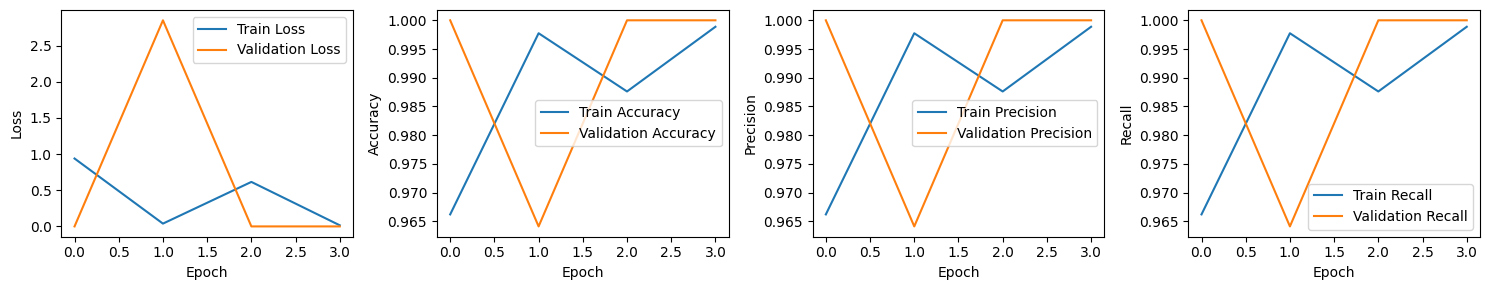

In [48]:
#plot curves
plot_curves(vgg_history, list(vgg_history.history.keys())[:4])

Found 279 validated image filenames belonging to 3 classes.
28/28 [==============================] - 17s 607ms/step


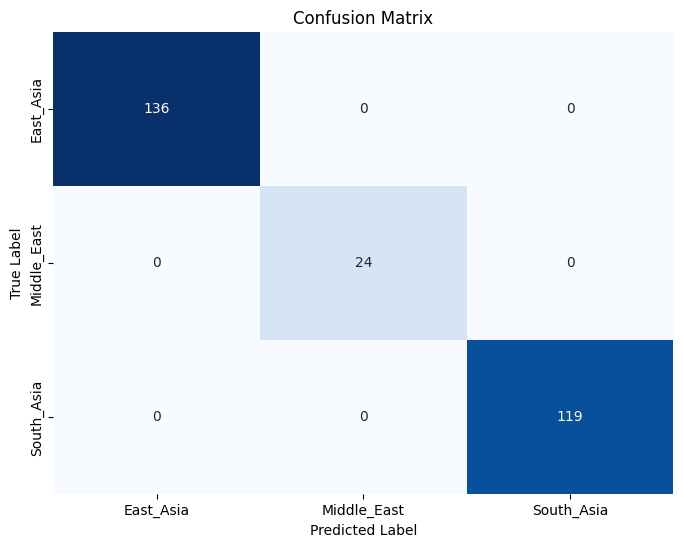

__Classification Report__ :
              precision    recall  f1-score   support

   East_Asia       1.00      1.00      1.00       136
 Middle_East       1.00      1.00      1.00        24
  South_Asia       1.00      1.00      1.00       119

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



In [19]:
# For loading model afterwards
# from keras.models import load_model
# model = load_model('Models/best_vgg16_model.h5')

plot_confusion_mat(model, test_df, keras.applications.vgg16.preprocess_input)

In [49]:

input_shape = (224, 224, 3)
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
ResNet50_model.trainable = False
print(ResNet50_model.summary())


model = Sequential()
model.add(tf.keras.layers.Reshape(input_shape))
model.add(ResNet50_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(3,activation='softmax'))
# model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6288 (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6288[0][0]']          
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [50]:
resnet_history = fit_model_KFoldCrossValidate(model, 'resnet50', keras.applications.resnet50.preprocess_input, train_df, test_df)



Fold 1
Found 888 validated image filenames belonging to 3 classes.
Found 223 validated image filenames belonging to 3 classes.
Epoch 1/4
89/89 [==============================] - 69s 732ms/step - loss: 1.0660 - accuracy: 0.9651 - precision_5: 0.9651 - recall_5: 0.9651 - val_loss: 0.0949 - val_accuracy: 0.9955 - val_precision_5: 0.9955 - val_recall_5: 0.9955
Epoch 2/4
89/89 [==============================] - 64s 720ms/step - loss: 0.2116 - accuracy: 0.9955 - precision_5: 0.9955 - recall_5: 0.9955 - val_loss: 8.5016e-05 - val_accuracy: 1.0000 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 3/4
89/89 [==============================] - 64s 714ms/step - loss: 0.2136 - accuracy: 0.9944 - precision_5: 0.9944 - recall_5: 0.9944 - val_loss: 1.0985 - val_accuracy: 0.9641 - val_precision_5: 0.9641 - val_recall_5: 0.9641
Epoch 4/4
89/89 [==============================] - 62s 697ms/step - loss: 0.4988 - accuracy: 0.9910 - precision_5: 0.9910 - recall_5: 0.9910 - val_loss: 0.0000e+00 - val_ac

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model

Fold 2
Found 889 validated image filenames belonging to 3 classes.
Found 222 validated image filenames belonging to 3 classes.
Epoch 1/4
89/89 [==============================] - 66s 708ms/step - loss: 3.6071e-08 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_6: 1.0000 - val_recall_6: 1.0000
Epoch 2/4
89/89 [==============================] - 62s 694ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_6: 1.0000 - val_recall_6: 1.0000
Epoch 3/4
89/89 [==============================] - 64s 723ms/step - loss: 0.3836 - accuracy: 0.9910 - precision_6: 0.9910 - recall_6: 0.9910 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_6: 1.0000 - val_recall_6: 1.0000
Epoch 4/4
89/89 [==============================] - 63s 703ms/step - loss: 1.0471 - accuracy: 0.9933 - precision_6: 0.9933 - recall_6: 0.9933 - v

In [59]:
resnet_history.history.g

{'loss': [1.06600821018219,
  0.2116096466779709,
  0.21356379985809326,
  0.4987981617450714],
 'accuracy': [0.9650900959968567,
  0.9954954981803894,
  0.994369387626648,
  0.9909909963607788],
 'precision_5': [0.9650900959968567,
  0.9954954981803894,
  0.994369387626648,
  0.9909909963607788],
 'recall_5': [0.9650900959968567,
  0.9954954981803894,
  0.994369387626648,
  0.9909909963607788],
 'val_loss': [0.09493089467287064,
  8.501567208440974e-05,
  1.0984731912612915,
  0.0],
 'val_accuracy': [0.9955157041549683, 1.0, 0.9641255736351013, 1.0],
 'val_precision_5': [0.9955157041549683, 1.0, 0.9641255736351013, 1.0],
 'val_recall_5': [0.9955157041549683, 1.0, 0.9641255736351013, 1.0]}

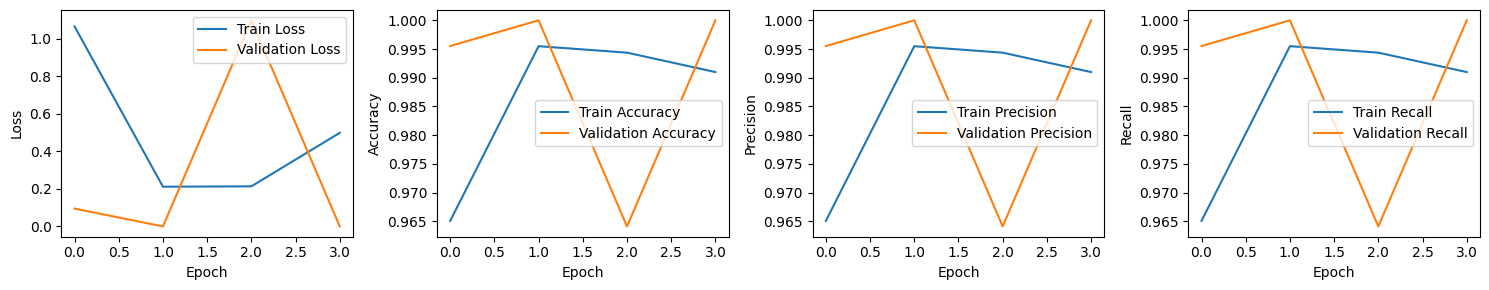

In [54]:
#plot curves
plot_curves(resnet_history, list(resnet_history.history.keys())[:4])

Found 279 validated image filenames belonging to 3 classes.
28/28 [==============================] - 11s 358ms/step


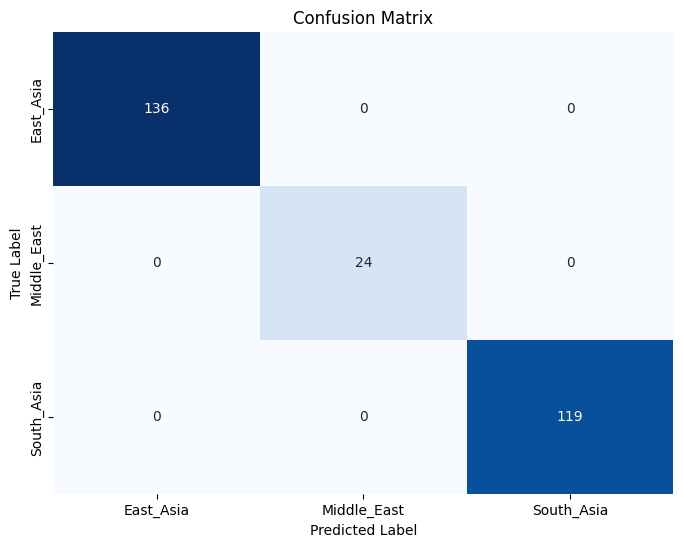

__Classification Report__ :
              precision    recall  f1-score   support

   East_Asia       1.00      1.00      1.00       136
 Middle_East       1.00      1.00      1.00        24
  South_Asia       1.00      1.00      1.00       119

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



In [20]:
# For loading model afterwards
# from keras.models import load_model
# model = load_model('Models/best_resnet50_model.h5')

plot_confusion_mat(model, test_df, keras.applications.resnet50.preprocess_input)

In [60]:
# MobileNet V2

input_shape = (224, 224, 3)
MobileNetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
MobileNetV2_model.trainable = False
print(MobileNetV2_model.summary())


model = Sequential()
model.add(tf.keras.layers.Reshape(input_shape))
model.add(MobileNetV2_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(3,activation='softmax'))
# model.summary()


9406464/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6289 (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_6289[0][0]']          
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [61]:
mobile_history = fit_model_KFoldCrossValidate(model, 'mobilenetv2', keras.applications.mobilenet_v2.preprocess_input, train_df, test_df)



Fold 1
Found 888 validated image filenames belonging to 3 classes.
Found 223 validated image filenames belonging to 3 classes.
Epoch 1/4
89/89 [==============================] - 35s 363ms/step - loss: 3.4471 - accuracy: 0.9302 - precision_10: 0.9323 - recall_10: 0.9302 - val_loss: 1.0984 - val_accuracy: 0.9507 - val_precision_10: 0.9507 - val_recall_10: 0.9507
Epoch 2/4
89/89 [==============================] - 32s 355ms/step - loss: 0.1231 - accuracy: 0.9966 - precision_10: 0.9966 - recall_10: 0.9966 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_10: 1.0000 - val_recall_10: 1.0000
Epoch 3/4
89/89 [==============================] - 31s 346ms/step - loss: 3.3743e-06 - accuracy: 1.0000 - precision_10: 1.0000 - recall_10: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_10: 1.0000 - val_recall_10: 1.0000
Epoch 4/4
89/89 [==============================] - 30s 335ms/step - loss: 1.7989e-08 - accuracy: 1.0000 - precision_10: 1.0000 - recall_10: 1.0000 - val

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model

Fold 2
Found 889 validated image filenames belonging to 3 classes.
Found 222 validated image filenames belonging to 3 classes.
Epoch 1/4
89/89 [==============================] - 34s 358ms/step - loss: 1.3409e-10 - accuracy: 1.0000 - precision_11: 1.0000 - recall_11: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_11: 1.0000 - val_recall_11: 1.0000
Epoch 2/4
89/89 [==============================] - 30s 337ms/step - loss: 0.7801 - accuracy: 0.9753 - precision_11: 0.9753 - recall_11: 0.9753 - val_loss: 0.1140 - val_accuracy: 0.9955 - val_precision_11: 0.9955 - val_recall_11: 0.9955
Epoch 3/4
89/89 [==============================] - 30s 339ms/step - loss: 0.2996 - accuracy: 0.9921 - precision_11: 0.9921 - recall_11: 0.9921 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_11: 1.0000 - val_recall_11: 1.0000
Epoch 4/4
89/89 [==============================] - 31s 343ms/step - loss: 4.8006e-06 - accuracy: 1.0000 - precision_11: 1.0000 - recall_11: 

In [62]:
mobile_history.history

{'loss': [3.447146415710449,
  0.12314189970493317,
  3.374326070115785e-06,
  1.798865589819343e-08],
 'accuracy': [0.9301801919937134, 0.9966216087341309, 1.0, 1.0],
 'precision_10': [0.9322798848152161, 0.9966216087341309, 1.0, 1.0],
 'recall_10': [0.9301801919937134, 0.9966216087341309, 1.0, 1.0],
 'val_loss': [1.0984001159667969, 0.0, 0.0, 0.0],
 'val_accuracy': [0.9506726264953613, 1.0, 1.0, 1.0],
 'val_precision_10': [0.9506726264953613, 1.0, 1.0, 1.0],
 'val_recall_10': [0.9506726264953613, 1.0, 1.0, 1.0]}

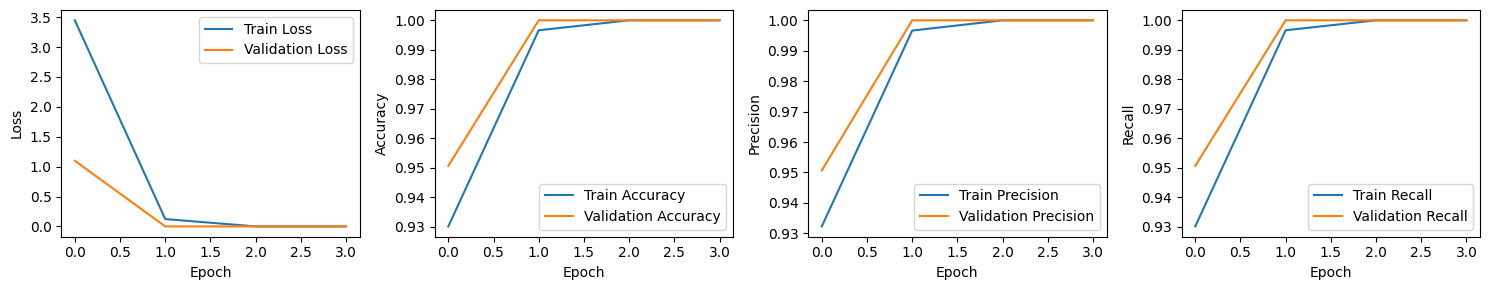

In [63]:
#plot curves
plot_curves(mobile_history, list(mobile_history.history.keys())[:4])

Found 279 validated image filenames belonging to 3 classes.
28/28 [==============================] - 4s 94ms/step


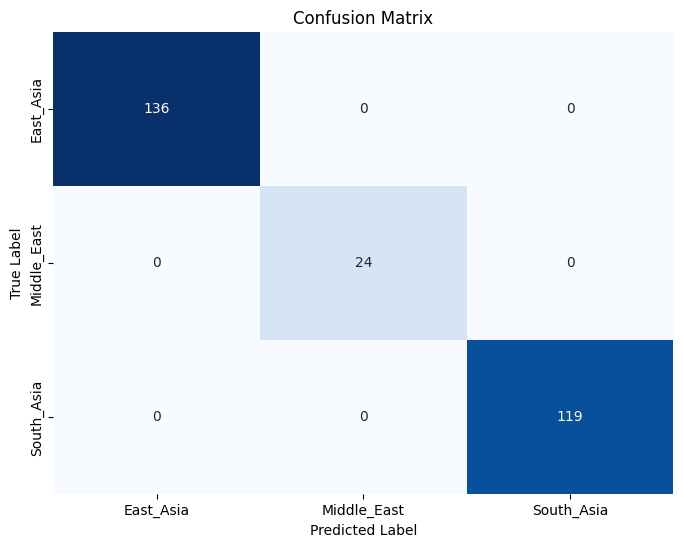

__Classification Report__ :
              precision    recall  f1-score   support

   East_Asia       1.00      1.00      1.00       136
 Middle_East       1.00      1.00      1.00        24
  South_Asia       1.00      1.00      1.00       119

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



In [21]:
# For loading model afterwards
# from keras.models import load_model
# model = load_model('Models/best_mobilenetv2_model.h5')

plot_confusion_mat(model, test_df, keras.applications.mobilenet_v2.preprocess_input)

**Best model (MobileNet V2) so far**

In [64]:
# Xception

input_shape = (224, 224, 3)
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
Xception_model.trainable = False
print(Xception_model.summary())


model = Sequential()
model.add(tf.keras.layers.Reshape(input_shape))
model.add(Xception_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(3,activation='softmax'))
# model.summary()


83683744/83683744 [==============================] - 24s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6290 (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_6290[0][0]']          
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activa

In [65]:
xception_history = fit_model_KFoldCrossValidate(model, 'xception', keras.applications.xception.preprocess_input, train_df, test_df)



Fold 1
Found 888 validated image filenames belonging to 3 classes.
Found 223 validated image filenames belonging to 3 classes.
Epoch 1/4
89/89 [==============================] - 60s 636ms/step - loss: 1.6231 - accuracy: 0.9527 - precision_15: 0.9602 - recall_15: 0.9505 - val_loss: 0.0807 - val_accuracy: 0.9955 - val_precision_15: 0.9955 - val_recall_15: 0.9955
Epoch 2/4
89/89 [==============================] - 56s 633ms/step - loss: 0.1390 - accuracy: 0.9899 - precision_15: 0.9899 - recall_15: 0.9899 - val_loss: 0.0327 - val_accuracy: 0.9910 - val_precision_15: 0.9910 - val_recall_15: 0.9910
Epoch 3/4
89/89 [==============================] - 56s 625ms/step - loss: 0.1415 - accuracy: 0.9921 - precision_15: 0.9921 - recall_15: 0.9921 - val_loss: 0.0819 - val_accuracy: 0.9955 - val_precision_15: 0.9955 - val_recall_15: 0.9955
Epoch 4/4
89/89 [==============================] - 57s 639ms/step - loss: 0.1705 - accuracy: 0.9932 - precision_15: 0.9932 - recall_15: 0.9932 - val_loss: 0.0180 - 

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model

Fold 2
Found 889 validated image filenames belonging to 3 classes.
Found 222 validated image filenames belonging to 3 classes.
Epoch 1/4
89/89 [==============================] - 63s 673ms/step - loss: 0.0496 - accuracy: 0.9966 - precision_16: 0.9966 - recall_16: 0.9966 - val_loss: 0.1439 - val_accuracy: 0.9955 - val_precision_16: 0.9955 - val_recall_16: 0.9955
Epoch 2/4
89/89 [==============================] - 57s 643ms/step - loss: 0.1458 - accuracy: 0.9910 - precision_16: 0.9910 - recall_16: 0.9910 - val_loss: 0.1453 - val_accuracy: 0.9955 - val_precision_16: 0.9955 - val_recall_16: 0.9955
Epoch 3/4
89/89 [==============================] - 56s 625ms/step - loss: 0.0976 - accuracy: 0.9921 - precision_16: 0.9921 - recall_16: 0.9921 - val_loss: 2.2097e-06 - val_accuracy: 1.0000 - val_precision_16: 1.0000 - val_recall_16: 1.0000
Epoch 4/4
89/89 [==============================] - 56s 624ms/step - loss: 0.2083 - accuracy: 0.9933 - precision_16: 0.9933 - recall_16: 0.9933 - val

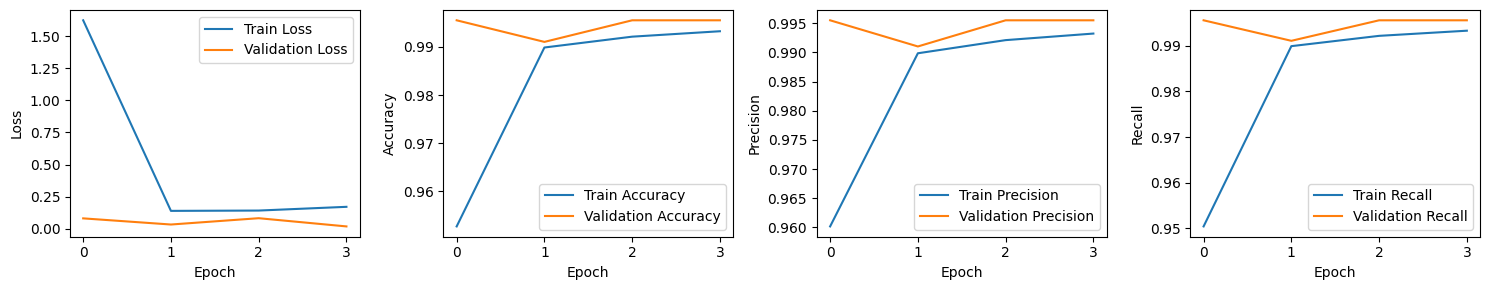

In [67]:
#plot curves
plot_curves(xception_history, list(xception_history.history.keys())[:4])

Found 279 validated image filenames belonging to 3 classes.
28/28 [==============================] - 9s 292ms/step


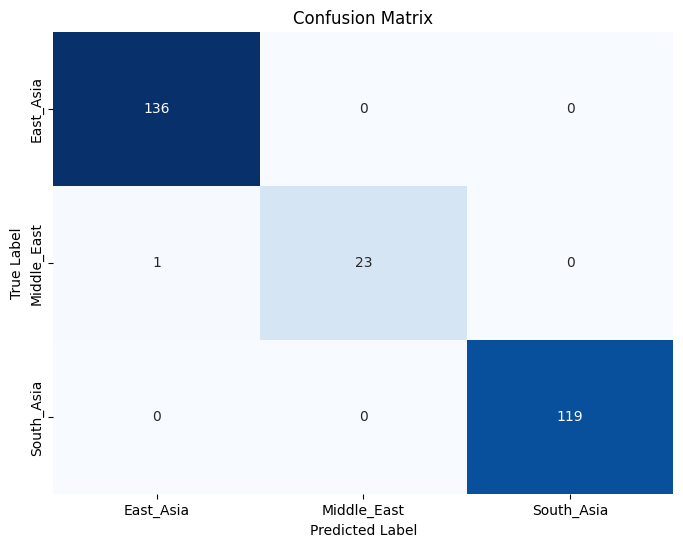

__Classification Report__ :
              precision    recall  f1-score   support

   East_Asia       0.99      1.00      1.00       136
 Middle_East       1.00      0.96      0.98        24
  South_Asia       1.00      1.00      1.00       119

    accuracy                           1.00       279
   macro avg       1.00      0.99      0.99       279
weighted avg       1.00      1.00      1.00       279



In [22]:
# For loading model afterwards
# from keras.models import load_model
# model = load_model('Models/best_xception_model.h5')

plot_confusion_mat(model, test_df, keras.applications.xception.preprocess_input)

In [100]:
test_df

,image_path,label
0,.//Train_Test_Sets/Test/South_Asia\South_Asia_...,South_Asia
1,.//Train_Test_Sets/Test/South_Asia\South_Asia_...,South_Asia
2,.//Train_Test_Sets/Test/South_Asia\South_Asia_...,South_Asia
3,.//Train_Test_Sets/Test/South_Asia\South_Asia_...,South_Asia
4,.//Train_Test_Sets/Test/South_Asia\South_Asia_...,South_Asia
...,...,...
274,.//Train_Test_Sets/Test/Middle_East\Middle_Eas...,Middle_East
275,.//Train_Test_Sets/Test/Middle_East\Middle_Eas...,Middle_East
276,.//Train_Test_Sets/Test/Middle_East\Middle_Eas...,Middle_East
277,.//Train_Test_Sets/Test/Middle_East\Middle_Eas...,Middle_East


## Random Forest, KNN, SGD classifiers

##### Memory uage of this section is high. If you get Memory error, restart the kernel or notebook and run the 2 (commented) cells below before the rest of this section.

In [ ]:

############## Uses

# # Read the CSV file
# data = pd.read_csv("./Dataset/asian_people.csv")

# # Create folders for classes
# classes = data['ethnicity'].str.replace(' ', '_').unique()
# for class_name in classes:
#     os.makedirs(class_name, exist_ok=True)
# classes

In [ ]:
# # Define function to get image paths
# def get_image_paths(directory):
#     image_paths = []
#     labels = []
#     for class_name in classes:
#         path = f'./{directory}/{class_name}'
#         # print(path)
#         class_images = [os.path.join(path, pics) for pics in os.listdir(path)]
#         image_paths.extend(class_images)
#         labels.extend([class_name] * len(class_images))
#     return image_paths, labels

# # Get image paths and labels for train and test sets
# train_dir = '/Train_Test_Sets/Train'
# test_dir = '/Train_Test_Sets/Test'

# train_image_paths, train_labels = get_image_paths(train_dir)
# test_image_paths, test_labels = get_image_paths(test_dir)

# # Create DataFrame for train set
# train_df = pd.DataFrame({'image_path': train_image_paths, 'label': train_labels})

# # Create DataFrame for test set
# test_df = pd.DataFrame({'image_path': test_image_paths, 'label': test_labels})

# # Print first few rows of train and test DataFrames
# print("Train DataFrame:")
# print(train_df.head())
# print("Test DataFrame:")
# print(test_df.head())


In [9]:
df = pd.concat([train_df, test_df], ignore_index=True, sort=False)
df

,image_path,label
0,.//Train_Test_Sets/Train/South_Asia\South_Asia...,South_Asia
1,.//Train_Test_Sets/Train/South_Asia\South_Asia...,South_Asia
2,.//Train_Test_Sets/Train/South_Asia\South_Asia...,South_Asia
3,.//Train_Test_Sets/Train/South_Asia\South_Asia...,South_Asia
4,.//Train_Test_Sets/Train/South_Asia\South_Asia...,South_Asia
...,...,...
1385,.//Train_Test_Sets/Test/Middle_East\Middle_Eas...,Middle_East
1386,.//Train_Test_Sets/Test/Middle_East\Middle_Eas...,Middle_East
1387,.//Train_Test_Sets/Test/Middle_East\Middle_Eas...,Middle_East
1388,.//Train_Test_Sets/Test/Middle_East\Middle_Eas...,Middle_East


In [10]:
len(df)

1390

In [11]:
images = []
labels = []

# Loop through each row in the DataFrame
for index, row in tqdm(df.iterrows(), total= len(df)):
    # Extract image path and label from the current row
    image_path = row['image_path']
    label = row['label']
    
    # Load image using OpenCV
    img = cv2.imread(image_path)
    
    # Check if the image is loaded successfully
    if img is not None:
        # Convert image to grayscale if needed
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        
        # Store image pixels and label
        images.append(img)
        labels.append(label)
    else:
        print(f"Failed to load image at {image_path}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

100%|██████████| 1390/1390 [00:02<00:00, 527.46it/s]


In [12]:
images.shape

(1390, 224, 224, 3)

In [13]:
_, nx, ny, ch = images.shape
data = images.reshape(-1, nx * ny * ch)

In [14]:
data.shape

(1390, 150528)

In [15]:
labels.shape

(1390,)

In [70]:

def get_score_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test), model
os.makedirs('Models', exist_ok=True)

folds = StratifiedKFold(n_splits=5)
max_knn, max_sgd, max_rf = 0, 0, 0
scores_knn = []
scores_sgd = []
scores_rf = []

for train_index, test_index in tqdm(folds.split(data, labels), total = 5):
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], labels[train_index], labels[test_index]

    from sklearn.utils import class_weight
    class_weight = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train) # As classes aren't balanced

    score_rf, model = get_score_model(RandomForestClassifier(n_estimators=10, 
                                                             class_weight={'East_Asia':class_weight[0] , 'Middle_East':class_weight[1], 'South_Asia':class_weight[2]}), 
                                                             X_train, X_test, y_train, y_test)
    if score_rf > max_rf:
        max_rf = score_rf
        joblib.dump(model, "./Models/best_rf_classifier.joblib")

    score_sgd, model = get_score_model(SGDClassifier(loss='log_loss', class_weight={'East_Asia':class_weight[0] , 'Middle_East':class_weight[1], 'South_Asia':class_weight[2]},
                                                     alpha=0.0001, max_iter=1000, random_state=42), 
                                                     X_train, X_test, y_train, y_test)
    if score_rf > max_sgd:
        max_sgd = score_sgd
        joblib.dump(model, "./Models/best_sgd_classifier.joblib")

    score_knn, model = get_score_model(KNeighborsClassifier(n_neighbors = 10), X_train, X_test, y_train, y_test)
    if score_knn > max_knn:
        max_knn = score_knn
        joblib.dump(model, "./Models/best_knn_classifier.joblib")
    
    scores_knn.append(score_knn)
    scores_rf.append(score_rf)
    scores_sgd.append(score_sgd)

print(f"KNN accuracies of 10 separate folds testing: {scores_knn}")
print(f"SGD accuracies of 10 separate folds testing: {scores_sgd}")
print(f"RF accuracies of 10 separate folds testing: {scores_rf}")

# Print the maximum scores achieved by each classifier
print("Max Random Forest Score:", max_rf)
print("Max SGD Score:", max_sgd)
print("Max KNN Score:", max_knn)


100%|██████████| 5/5 [00:53<00:00, 10.73s/it]

KNN accuracies of 10 separate folds testing: [0.9748201438848921, 0.9892086330935251, 1.0, 0.9856115107913669, 0.9964028776978417]
SGD accuracies of 10 separate folds testing: [0.9892086330935251, 0.9784172661870504, 1.0, 0.960431654676259, 0.9892086330935251]
RF accuracies of 10 separate folds testing: [0.9748201438848921, 0.9856115107913669, 0.9964028776978417, 0.8992805755395683, 0.9928057553956835]
Max Random Forest Score: 0.9964028776978417
Max SGD Score: 1.0
Max KNN Score: 1.0


In [ ]:
# Confusion matrix and classification report

def train_report(model, X_test, y_test):

    predictions = model.predict(X_test)


    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                # xticklabels=["South Asia", "Middle East", "East Asia"], yticklabels=["South Asia", "Middle East", "East Asia"]
                )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Generate classification report
    report = classification_report(y_test, predictions)

    print("__Classification Report__ :")
    print(report)

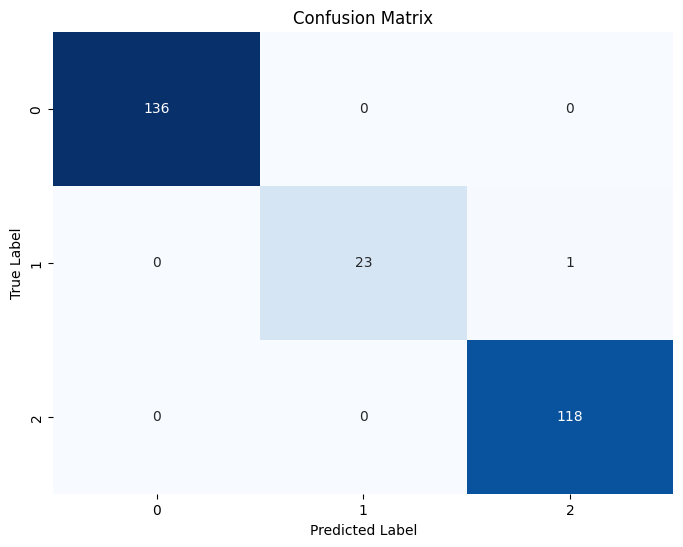

__Classification Report__ :
              precision    recall  f1-score   support

   East_Asia       1.00      1.00      1.00       136
 Middle_East       1.00      0.96      0.98        24
  South_Asia       0.99      1.00      1.00       118

    accuracy                           1.00       278
   macro avg       1.00      0.99      0.99       278
weighted avg       1.00      1.00      1.00       278



In [61]:
model = joblib.load('Models/best_knn_classifier.joblib')
train_report(model, X_test, y_test)

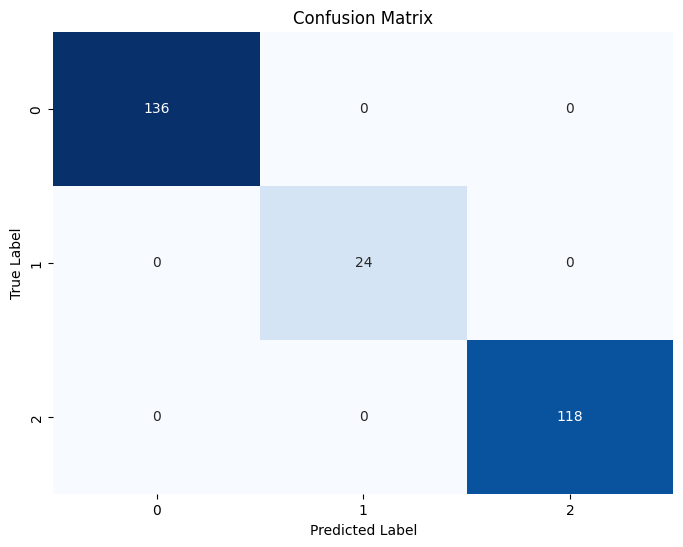

__Classification Report__ :
              precision    recall  f1-score   support

   East_Asia       1.00      1.00      1.00       136
 Middle_East       1.00      1.00      1.00        24
  South_Asia       1.00      1.00      1.00       118

    accuracy                           1.00       278
   macro avg       1.00      1.00      1.00       278
weighted avg       1.00      1.00      1.00       278



In [62]:
model = joblib.load('Models/best_sgd_classifier.joblib')
train_report(model, X_test, y_test)

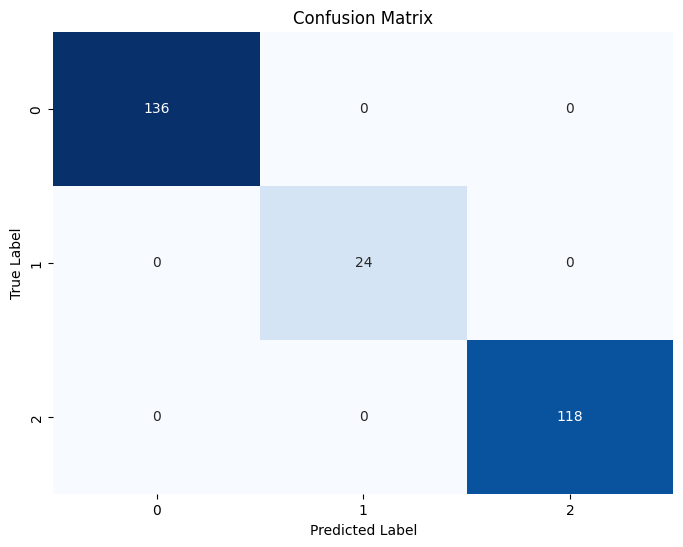

__Classification Report__ :
              precision    recall  f1-score   support

   East_Asia       1.00      1.00      1.00       136
 Middle_East       1.00      1.00      1.00        24
  South_Asia       1.00      1.00      1.00       118

    accuracy                           1.00       278
   macro avg       1.00      1.00      1.00       278
weighted avg       1.00      1.00      1.00       278



In [84]:
model = joblib.load('Models/best_rf_classifier.joblib')
train_report(model, X_test, y_test)

Here RF and SGD are performing better than KNN

In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# # from tensorflow.keras.applications.vgg16 import preprocess_input

# # Define the folder containing images
# folder_path = "random"
# model = joblib.load('Models/best_knn_classifier.joblib')
# c=0
# # Iterate through each image in the folder
# for filename in os.listdir(folder_path):
#     # Load the image
#     image_path = os.path.join(folder_path, filename)
    
#     # Preprocess the image
#     img_array = extract_face(image_path)
#     plt.imshow(img_array)
#     img_array = img_array.reshape((1,) + img_array.shape)
#     if 'South_Asia' in filename:
#         actual = "South Asia"
#     # Check if filename contains Middle_East label
#     elif 'Middle_East' in filename:
#         actual = "Middle East"

#     # Check if filename contains East_Asia label
#     elif 'East_Asia' in filename:
#         actual = "East Asia"

#     else:
#         actual = "Unknown"



#     # Predict the class probabilities
#     _, nx, ny, ch = img_array.shape
#     img_array = img_array.reshape(-1, nx * ny * ch)
#     predictions = model.predict(img_array)
#     print(predictions)
#     if predictions == "South_Asia":
#         predict = "South Asia"
#     elif predictions == "Middle_East":
#         predict = "Middle East"
#     else:
#         predict = "East Asia"
#     print(f"pred = {predict},  actual = {actual}")
#     if actual == predict:
#         c+=1
#     # # Decode the predictions to get the class labels
#     # decoded_predictions = decode_predictions(predictions)
#     # class_label = decoded_predictions[0][0][1]  # Get the predictions of the top prediction
    
#     # Plot the image with the predicted class predictions underneath
#     # plt.imshow(img)
#     # plt.title(f"Predicted: {predict}, actual = {actual}")
#     # plt.axis('off')
#     # plt.show()
# print(f"Acc = {c}/{len(os.listdir(folder_path))}")

In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# # from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.resnet50 import preprocess_input

# # Define the folder containing images
# folder_path = "random"
# model = load_model('Models/best_resnet50_model.h5')
# c=0
# # Iterate through each image in the folder
# for filename in os.listdir(folder_path):
#     # Load the image
#     image_path = os.path.join(folder_path, filename)
    
#     # Preprocess the image
#     img_array = extract_face(image_path)
#     plt.imshow(img_array)
#     img_array = preprocess_input(img_array)
#     img_array = img_array.reshape((1,) + img_array.shape)
#     if 'South_Asia' in filename:
#         actual = "South Asia"
#     # Check if filename contains Middle_East label
#     elif 'Middle_East' in filename:
#         actual = "Middle East"

#     # Check if filename contains East_Asia label
#     elif 'East_Asia' in filename:
#         actual = "East Asia"

#     else:
#         actual = "Unknown"



#     # Predict the class probabilities
#     predictions = model.predict(img_array)
#     if np.array_equal(predictions, [[0, 0, 1]]):
#         predict = "South Asia"
#     elif np.array_equal(predictions, [[0, 1, 0]]):
#         predict = "Middle East"
#     else:
#         predict = "East Asia"
#     print(f"pred = {predict},  actual = {actual}")
#     if actual == predict:
#         c+=1
#     # # Decode the predictions to get the class labels
#     # decoded_predictions = decode_predictions(predictions)
#     # class_label = decoded_predictions[0][0][1]  # Get the predictions of the top prediction
    
#     # Plot the image with the predicted class predictions underneath
#     # plt.imshow(img)
#     # plt.title(f"Predicted: {predict}, actual = {actual}")
#     # plt.axis('off')
#     # plt.show()
# print(f"Acc = {c}/{len(os.listdir(folder_path))}")